In [130]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
from langchain.vectorstores import Chroma
import yaml
from langchain.embeddings import HuggingFaceEmbeddings
import tempfile
import shutil
import numpy as np
from transformers import AutoTokenizer

In [70]:
def copy_to_temp_folder(source_folder:str):
    # create a temporary folder
    temp_folder = tempfile.mkdtemp()

    # copy files to temporary folder
    for item in os.listdir(source_folder):
        s = os.path.join(source_folder, item)
        d = os.path.join(temp_folder, item)
        if os.path.isdir(s):
            shutil.copytree(s, d)
        else:
            shutil.copy2(s, d)

    return temp_folder

In [71]:
# Specify the path to your YAML file
file_path_yaml = "./dvc.yaml"

# Open the YAML file and load its contents into a Python object
with open(file_path_yaml, 'r') as f:
    dvc_parameters = yaml.safe_load(f)

args = dvc_parameters['stages']['eval_retrieval_question_gen']['cmd'].split()

vector_database_filename = args[2]

In [72]:
# load embedder
embedder = HuggingFaceEmbeddings(model_name=dvc_parameters['stages']['build_embedder']['cmd'].split()[2].replace('"', ''))

In [73]:
temp = copy_to_temp_folder(vector_database_filename)
vectorstore = Chroma(persist_directory=temp, embedding_function=embedder)

In [74]:
df_questions = pd.read_parquet(dvc_parameters['stages']['eval_retrieval_question_gen']['cmd'].split()[4])

# Einführung und Setup
Dieses Notebook dokumentiert unsere Evaluation der Qualität des retrieval Prozesses. Sie basiert auf Resultaten der DVC Stage `eval_retrieval_metrics.py`, welche den reciprocal rank für Dokumente, die von einem ausgesuchten Embedder (hier `distiluse-base-multilingual-cased-v1`) als relevant eingestuft wurden, bestimmt und daraus den Mean reciprocal rank berechnet. Die Resultate dieser Stage werden im Ordner `data/processed` abgelegt und können mittels `dvc pull` bezogen werden, sofern die benötigten Berechtigungen vorhanden sind.   

# Reciprocal rank und mean reciprocal rank  
 Der reciprocal rank gibt an, an welcher Stelle das korrekte Dokument durch den Embedder empfohlen worden ist. In diesem Fall steht das korrekte Dokument für jenes, welches genutzt worden ist, um mit dem llm `LeoLM/leo-mistral-hessianai-7b-chat` die im hier verwendeten Datensatz vorhandene Frage zu generieren. Wenn das Modell stets die korrekte Rückmeldung liefert, würde der Rank für jedes Dokument 1 sein.  
 
Aus einer Liste solcher Rankings kann dann eine zusammenfassende Metrik, der mean reciprocal rank, berechnet werden. Die Formel dafür lautet wie folgt:  
$$
 \text{MRR} = \sum_{i=1}^{|Q|}\frac{1}{\text{rank}_i}
$$
wobei:
- $|Q|$: die Anzahl gestellter Fragen
- $\text{rank}$: der reciprocal rank

Dieser Durchschnittswert entspricht dem harmonischen Mittel der Ranks. 

In [79]:
# read ranks data
ranks_file_path = "./data/processed/eval_retrieval_ranks.csv"

if os.path.isfile(ranks_file_path):
    df_ranks = pd.read_csv(ranks_file_path)
    print(df_ranks.head())
else:
    print("Ranks file is not available, please provide it using dvc")

   Unnamed: 0  \
0           0   
1           1   
2           2   
3           3   
4           4   

                                                                                                                question  \
0                    Was ist das Ausbildungskonzept für den Studiengang Data Science an der Hochschule für Technik FHNW?   
1                                    Was ist das Ziel des Ausbildungskonzepts laut dem Inhaltsverzeichnis des Dokuments?   
2                                                                 Was wird auf den Seiten 3 bis 22 des Inputs behandelt?   
3                                       Welches Ziel hat die Bachelor-Ausbildung an der Hochschule für Technik der FHNW?   
4  Was ist das Ziel des Studiengangs Data Science und wie bereiten sie die Studierenden auf die heutige Arbeitswelt vor?   

   rank  
0    11  
1    15  
2   146  
3     1  
4   211  


In [80]:
df_ranks.drop(columns=df_ranks.columns[0], inplace=True)
df_ranks['id'] = df_questions[['id']].reset_index(drop=True)

In [81]:
# Assuming df is your DataFrame and vectorstore is your VectorStore instance
df_ranks['document_chunk'] = df_ranks['id'].apply(lambda x: vectorstore.get(x)["documents"][0])

In [82]:
# read mrr 
mrr_file_path = "./data/processed/eval_retrieval_metrics.json"

if os.path.isfile(mrr_file_path):
    with open(mrr_file_path, 'r') as f:
      mrr = json.load(f)
    print(mrr)
else:
    print("Metrics file is not available, please provide it using dvc")

{'mrr': 0.5115116621454743}


# MRR
In unserem Test haben wir einen MRR von rund 0.512 erreicht. Da es sich aber um einen Mittelwert handelt, überprüfen wir nachfolgend die Verteilung der Rankings und allfällige Ausreisser.

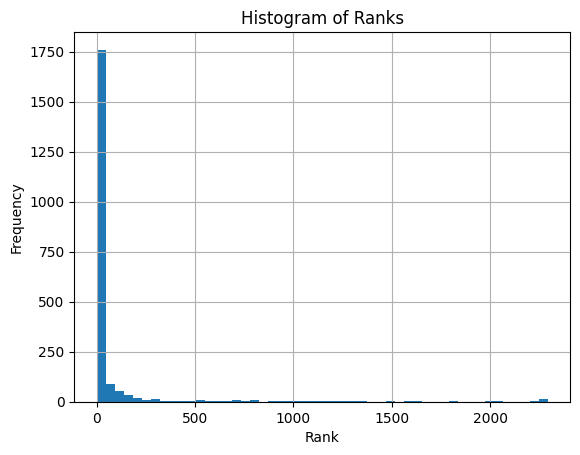

In [83]:
# Plot histogram
df_ranks['rank'].hist(bins=50)

# Add labels and title
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Histogram of Ranks')
# Show the plot
plt.show()

In diesem Plot ist die Verteilung der aufgezeichneten reciprocal ranks zu sehen. Auffällig ist, dass sehr viele sich im Bereich von 1 befinden und ein paar wenige Observationen einen Rank von > 2000 erreicht haben. Nachfolgend wird die Verteilung der Observationen genauer untersucht. 

In [84]:
df_ranks['rank'].describe()

count    2123.000000
mean       91.640603
std       316.300130
min         1.000000
25%         1.000000
50%         2.000000
75%        20.000000
max      2294.000000
Name: rank, dtype: float64

75% der aufgezeichneten Rankings weisen einen Wert von 20 oder weniger auf, wobei der grösste erreichte Wert bei 2294 liegt. Für einen im Verhältnis kleinen Anteil der Fragen mussten also deutlich mehr Dokumente vorgeschlagen werden, bis das richtige gefunden wurde. Da es sich beim MRR um ein harmonisches Mittel handelt, bewegen diese wenigen Ausreisser den MRR mehr gegen 0. Trotz einem relativ schwachen MRR von 0.512 werden sehr viele Dokumente im ersten Versuch korrekt identifiziert. Bei welchen Dokumenten das nicht passiert, wird nachfolgend genauer untersucht.      

In [87]:
pd.set_option('display.max_colwidth', None)
df_ranks.nlargest(10, 'rank')

,question,rank,id,document_chunk
1188,Welche Auswirkungen hat die Abholzung auf die Tierwelt und ihre Lebensräume?,2294,63cbbe26-a096-11ee-8f10-bc091bcbe1c4,nicht vorgesehen
1187,Welche Auswirkungen hat die Abholzung auf die Tierwelt und ihre Lebensräume?,2293,63cbbe25-a096-11ee-aaef-bc091bcbe1c4,nicht vorgesehen
290,Welche Herausforderungen und Chancen ergeben sich durch die schnelle Verbreitung von Technologie in unserem Leben?,2292,63cb6fc1-a096-11ee-83dd-bc091bcbe1c4,-
1811,"Wie viele ganze Zahlen gibt es in der Liste $ 2000, 2001, 2002, \ldots, 4000$?",2285,63cbe610-a096-11ee-9b6d-bc091bcbe1c4,\n \n
1475,Wie viele positive ganze Zahlen kleiner als 100 haben eine gerade Anzahl von Teilern?,2268,63cbbf60-a096-11ee-9e16-bc091bcbe1c4,Nicht vorgesehen.
1474,Wie viele positive ganze Zahlen kleiner als 100 haben eine gerade Anzahl von Teilern?,2267,63cbbf5f-a096-11ee-86aa-bc091bcbe1c4,Nicht vorgesehen.
1345,Wie viele positive ganze Zahlen kleiner als 100 haben eine gerade Anzahl von Teilern?,2266,63cbbed8-a096-11ee-bbfe-bc091bcbe1c4,Nicht vorgesehen.
1200,Wie viele positive ganze Zahlen kleiner als 100 haben eine gerade Anzahl von Teilern?,2265,63cbbe32-a096-11ee-be56-bc091bcbe1c4,Nicht vorgesehen.
942,Wie viele positive ganze Zahlen kleiner als 100 haben eine gerade Anzahl von Teilern?,2264,63cb97c7-a096-11ee-888e-bc091bcbe1c4,Nicht vorgesehen.
956,Wie viele positive ganze Zahlen kleiner als 100 haben eine gerade Anzahl von Teilern?,2263,63cb97d5-a096-11ee-9d84-bc091bcbe1c4,Nicht vorgesehen.


In [88]:
df_ranks.nsmallest(10, 'rank')

,question,rank,id,document_chunk
3,Welches Ziel hat die Bachelor-Ausbildung an der Hochschule für Technik der FHNW?,1,63cb4886-a096-11ee-a3dd-bc091bcbe1c4,"Seite 4/22 \n \n 1 Vorwort \n \nDie Bachelor -Ausbildung an der Hochschule für Technik der FHNW hat die nachhaltige Berufs-\nbefähigung von Absolventinnen und Absolventen zum Ziel. Die Digitalisierung und rasch wan-\ndelnden gesellschaftlichen Rahmenbedingungen widerspiegeln sich naturgemäss auch in der Ar-\nbeitswelt, welche neue Anforderungen an Absolventinnen und Absolventen und somit auch an \nAusbildungsinstitutionen stellt . Das Ausbildungskonzept ist eine Antwort auf diesen Wandel . \nEs setzt sich zum Ziel , die Digitalisierung zu nutzen und die Studierenden konsequent in den \nMittelpunkt des Lernprozesses zu stellen, damit sie sich bereits während des Studium s zu eigen-\nständigen Autodidakten entwickeln und für die lebenslange Lernreise gut vorber eitet sind. N ebst \ndem Erwerb von fachlichen Kompetenzen, wird ein Augenmerk auf die Entwicklung von Selbst - \nund Sozialkompetenz der Studierenden gelegt. \nMit dem Ausbildungskonzept beschreiten wir neue Wege. Es liegt in der Natur von innovativen \nVorhaben, das s nach dem ersten Wurf einige weitere Anpassungsschritte notwendig werden. \nDas wird bei diese m Ausbildungskonzept nicht anders sein: wir laden sämtliche Beteiligte ein, die \nWeiterentwicklung des Ausbildungskonzeptes durch Feedbacks und Inputs mitzuprägen."
20,Wie viele Studierende haben Prüfungen von Modulen im Gegenwert von 60 Credits nicht bestanden?,1,63cb4898-a096-11ee-aaea-bc091bcbe1c4,"Seite 22/22 \n \n - Studierende, die Prüfungen von Modulen im Gegenwert von 60 Credits nicht bestanden \nhaben."
26,"Wie viele Credits muss ein Student im Studiengang Data Science erwerben, um den Bachelor-Abschluss zu erreichen?",1,63cb489e-a096-11ee-8aa9-bc091bcbe1c4,"Seite 6/17 \n \n Bei Erfüllung aller Modulgruppen mit der minimalen Anzahl Credits sind die für den Bachelor -\nAbschluss erforderlichen 180 Credits noch nicht erreicht. Die fehlenden Credits können durch \ndas Besuchen von weiteren, frei gewählten Modulen aus den Modulgruppen des Curriculums \n(oder auch darüber hinaus1) erworben werden. Damit wird das Studium indivi dualisierbar, \nd.h. jede/ r Studierende kann gemäss eigener Präferenz Stärken ausbauen, Schwächen aus-\nbügeln oder in der Breite und Tiefe der Ausbildung einen eigenen Fokus setzen . Dieses Sys-\ntem hat aber eine Kehrseite: jede/ r Studierende muss ihr/sein Studium selbst planen. \nDer Transcript of Records (ToR, vgl. Kapitel 6.5.1) gibt Auskunft darüber, wie welche Module \nbestanden wurden , wie viel e Credits erworben wurden und ob die jeweiligen Modulgruppen \nerfüllt sind. \n \n3.2.1 Module \nJedes Modul ist durch eine Modulbeschreibung definiert. Darin sind Titel, Inhalte, Anzahl Cre-\ndits, Anspruchsniveau, Modulbewertung (Note oder Testat erfüllt/nicht erfüllt ) sowie die erwarte-\nten Lernergebnisse definiert. Letztere dienen als Indikator für den im Modul vorgesehenen bzw. \nerwarteten Kompetenzerwerb. Die Modulbeschreibungen finden sich auf der Homepage des \nStudiengangs im verlinkten Curricul um (https://www.fhnw.ch/de/studium/technik/data- science ), \nals auch im StudentHub ersichtlich. \nIm Studiengang D ata Science sind vier unterschiedliche Modultypen vorgesehen, die einem un-\nterschiedliche n Zweck dienen und zu deren Erfüllung unterschiedliche Regeln gelten. \n \nIn der Übersicht Kompetenzmodule ist der gesamte Studienaufbau dargestellt. \nDarauf ist ersichtlich, wann sämtliche Kompetenzmodule angeboten werden. Dieses Dokument \nist auf Spaces abgelegt. \n \n \n \n \n \n1 Gemäss Studienreglement ist der Erwerb von mindestens 172 Credits aus dem Curriculum des Studiengangs Data \nScience Pflicht. Die restlichen 8 Credits können beliebig aus den Curricula anderer Studiengänge bzw. anderer \nHochschulen erworben werden. Diese werden dann als sog. ""freie Credits"" verbucht."
36,Was sind die Rechte und Pflichten d

In [96]:
df_ranks = df_ranks[df_ranks['document_chunk'].str.len() >= 100]
df_ranks

,question,rank,id,document_chunk
0,Was ist das Ausbildungskonzept für den Studiengang Data Science an der Hochschule für Technik FHNW?,11,63cb4883-a096-11ee-97aa-bc091bcbe1c4,Hochschule für Technik FHNW \nStudiengang Data Science Bahnhofstrasse 6 \n5210 Windisch T +41 56 202 86 45 data-science.technik @fhnw.ch \nwww.fhnw.ch \n \nAusbildungskonzept Studiengang Data Science FHNW \n \n \n \n \n \n \n \n \n \n \nVerfasst durch das Studiengangt eam Data Science \n \nStudiengangsleitung Rocco Custer rocco.custer@fhnw.ch \nAdmin & Anlässe Myriame Corsellini myriam.corsellini@fhnw.ch \nDidaktik + Coaching Petra Soder petra.soder@fhnw.ch \nnavigate! Coaches Christian Föllmi christian.foellmi@fhnw.ch \n Robert Espenschied robert.espenschied@fhnw.ch \nSpaces Plattform Rafael Schwemmer rafael.schwemmer@fhnw.ch \n Fabian Jordi fabian.jordi@fhnw.ch \n Lukas Märki l ukas.maerki@fhnw.ch \nEhem. Leitung Didaktik DS Monika Schlatter monika.schlatter@fhnw.ch \n \n \n \n \n \nVersio n: 01. September 202 3
1,Was ist das Ziel des Ausbildungskonzepts laut dem Inhaltsverzeichnis des Dokuments?,15,63cb4884-a096-11ee-bf89-bc091bcbe1c4,Seite 2/22 \n \n Inhaltsverzeichnis \n \n1 Vorwort 4 \n2 Einführung 5 \n2.1 Einordnung des Dokuments 5 \n2.2 Rahmenbedingungen für die Entwicklung des Ausbildungskonzeptes 5 \n2.3 Zielsetzungen für die Entwicklung des Ausbildungskonzeptes 5 \n3 Grundsätze Ausbildungskonzept 6 \n4 Beteiligte 9 \n5 Curriculum 10 \n5.1 Kompetenzmodule 11 \n5.2 Praxismodule 12 \n6 Kompetenzerwerb und dessen Unterstützung durch den Studiengang 12 \n6.1 Kompetenzmodule 12 \n6.1.1 Basismodule 13 \n6.1.2 Portfoliomodule 13 \n6.2 Praxismodule 14 \n6.2.1 Challenges 14 \n6.2.2 Projekte 14 \n6.3 Kompetenzerwerb in beruflichen oder privaten Kontext (Praxisportfolio) 15 \n6.4 Modulübergreifender Kompetenzerwerb und Begleitung navigate! Coaching 15 \n6.4.1 Begleitung navigate! Coaching 16 \n6.4.2 Selbstmanagement (im Lernprozess) 16 \n7 Kompetenznachweise 16 \n7.1 Kompetenzmodul 16 \n7.1.1 Kompetenznachweisformen 17 \n7.1.2 Praxisportfolio und - gespräch 17 \n7.1.3 Terminierung der K ompetenznachweise 17 \n7.1.4 Kommunikation an Studierende 18 \n7.1.5 Noteneingabe und -kommunikation 18 \n7.2 Praxismodule 18 \n7.2.1 Challenges 18 \n7.2.2 Projekte 19 \n8 Digitale und räumliche Infrastruktur 19 \n9 Studienablauf 20 \n9.1 Studienzulassung 20 \n9.2 Anrechnung von Credits aus Vorleistungen 20
2,Was wird auf den Seiten 3 bis 22 des Inputs behandelt?,146,63cb4885-a096-11ee-b3c5-bc091bcbe1c4,Seite 3/22 \n \n 9.3 Semesterablauf 20 \n9.4 Assessmentphase 21 \n9.5 Studiendauer 21 \n9.6 Erfolgreicher Studienabschluss und Diplom 21 \n9.7 Exmatrikulation 21
3,Welches Ziel hat die Bachelor-Ausbildung an der Hochschule für Technik der FHNW?,1,63cb4886-a096-11ee-a3dd-bc091bcbe1c4,"Seite 4/22 \n \n 1 Vorwort \n \nDie Bachelor -Ausbildung an der Hochschule für Technik der FHNW hat die nachhaltige Berufs-\nbefähigung von Absolventinnen und Absolventen zum Ziel. Die Digitalisierung und rasch wan-\ndelnden gesellschaftlichen Rahmenbedingungen widerspiegeln sich naturgemäss auch in der Ar-\nbeitswelt, welche neue Anforderungen an Absolventinnen und Absolventen und somit auch an \nAusbildungsinstitutionen stellt . Das Ausbildungskonzept ist eine Antwort auf diesen Wandel . \nEs setzt sich zum Ziel , die Digitalisierung zu nutzen und die Studierenden konsequent in den \nMittelpunkt des Lernprozesses zu stellen, damit sie sich bereits während des Studium s zu eigen-\nständigen Autodidakten entwickeln und für die lebenslange Lernreise gut vorber eitet sind. N ebst \ndem Erwerb von fachlichen Kompetenzen, wird ein Augenmerk auf die Entwicklung von Selbst - \nund Sozialkompetenz der Studierenden gelegt. \nMit dem Ausbildungskonzept beschreiten wir neue Wege. Es liegt in der Natur von innovativen \nVorhaben, das s nach dem ersten Wurf einige weitere Anpassungsschritte notwendig werden. \nDas wird bei diese m Ausbildungskonzept nicht anders sein: wir laden sämtliche Beteiligte ein, die

In [97]:
df_ranks.describe()

,rank
count,1887.000000
mean,73.715421
std,256.763292
min,1.000000
25%,1.000000
50%,2.000000
75%,16.000000
max,2250.000000


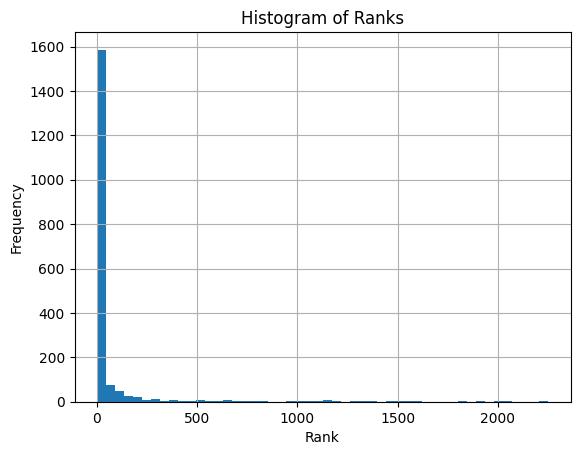

In [90]:
# Plot histogram
df_ranks['rank'].hist(bins=50)

# Add labels and title
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Histogram of Ranks')
# Show the plot
plt.show()

In [95]:
np.mean(1 / np.array(df_ranks['rank']))

0.5160862836469495

In [98]:
4096 sehr gut
< 32000 dann schlecht

37     3980
4      3664
12     3556
67     3494
247    3481
Name: document_chunk, dtype: int64

In [131]:
# Initialize an empty dictionary to store the embeddings
tokens = []
tokenizer = AutoTokenizer.from_pretrained("VAGOsolutions/SauerkrautLM-7b-v1-mistral")
# Iterate over all the IDs in the VectorStore
for id in vectorstore.get()["ids"]:
    # Retrieve the documents for the current ID
    documents = vectorstore.get(id)["documents"]
    
    # Create an embedding for each document
    for document in documents:
        token = tokenizer.tokenize(document)
        tokens.append(token)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [133]:
# Calculate the length of each list of tokens
lengths = [len(token_list) for token_list in tokens]

# Find the maximum length
max_length = max(lengths)

# Print the maximum length
print(max_length)

1644


In [138]:
import heapq

# Find the largest 4 lengths
largest_lengths = heapq.nlargest(4, lengths)

# Sum the largest 4 lengths
sum_largest_lengths = sum(largest_lengths)

# Print the sum of the largest 4 lengths
print(sum_largest_lengths)

5689


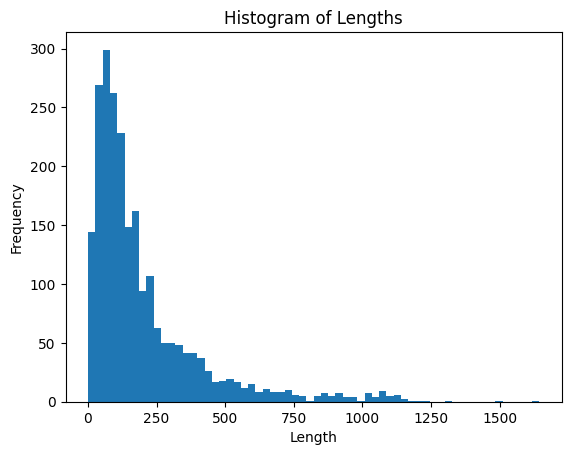

In [139]:
import matplotlib.pyplot as plt

# Create a histogram of the lengths
plt.hist(lengths, bins='auto')

# Set the title and labels
plt.title('Histogram of Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Show the plot
plt.show()